<a href="https://colab.research.google.com/github/Supakrit65/CIFAR10-Classification-MiniVGG/blob/main/minivgg_cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset

# Plot ad hoc CIFAR10 instances
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

## Load the CIFAR-10 Dataset in Keras

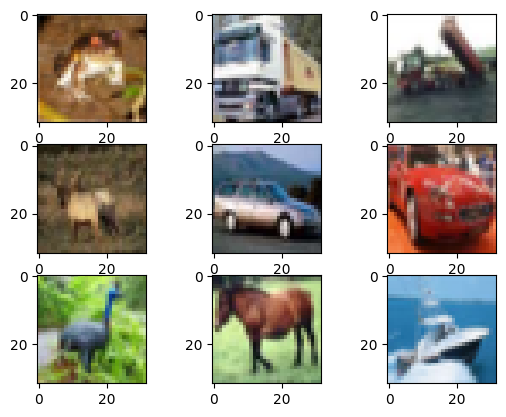

In [2]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
 plt.subplot(330 + 1 + i)
 plt.imshow(X_train[i])
# show the plot
plt.show()

In [3]:
IMG_SIZE = X_train.shape[1]
print("IMG_SIZE:", IMG_SIZE)
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

IMG_SIZE: 32
X_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
X_test.shape: (10000, 32, 32, 3)
y_test.shape: (10000, 1)


One-Hot encode labels to (N, num_class)

In [4]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Use tf.data.Dataset API

In [5]:
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
test_dataset = Dataset.from_tensor_slices((X_test, y_test))

### Normalize inputs to 0-1

In [6]:
# Function to normalize images
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Apply the normalization preprocessing to the datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Apply the Augmentation to the Training Dataset:

In [7]:
def augment(image, label):
    # Randomly flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Randomly change the brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Randomly change the contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # You can add more augmentations as needed

    return image, label

train_dataset = train_dataset.map(augment)

## Set up shuffle and batch

In [8]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# one hot encode outputs
y_train = to_categorical(y_train)
print('new y_train.shape:', y_train.shape)
y_test = to_categorical(y_test)
print('new y_test.shape:', y_test.shape)
num_classes = y_test.shape[1]
print("num_class:",num_classes)

new y_train.shape: (50000, 10, 2)
new y_test.shape: (10000, 10, 2)
num_class: 10


## Build and Compile MiniVGGNet model

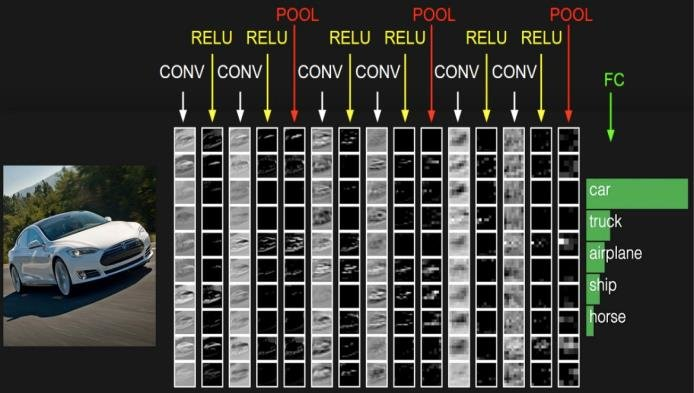

In [11]:
def MiniVGGNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First Conv Block
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second Conv Block
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(300, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs, name='MiniVGGNet')
    return model

In [12]:
model = MiniVGGNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "MiniVGGNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0

## Train model

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

h = model.fit(train_dataset, validation_data=test_dataset, epochs=30, callbacks=[checkpoint])

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 1.4944 - accuracy: 0.4786
Epoch 1: val_loss improved from inf to 1.43254, saving model to best_model.keras
1563/1563 [==============================] - 36s 14ms/step - loss: 1.4944 - accuracy: 0.4786 - val_loss: 1.4325 - val_accuracy: 0.5329
Epoch 2/30
1560/1563 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.6348
Epoch 2: val_loss improved from 1.43254 to 0.96097, saving model to best_model.keras
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0393 - accuracy: 0.6347 - val_loss: 0.9610 - val_accuracy: 0.6621
Epoch 3/30
1558/1563 [============================>.] - ETA: 0s - loss: 0.9102 - accuracy: 0.6836
Epoch 3: val_loss improved from 0.96097 to 0.83406, saving model to best_model.keras
1563/1563 [==============================] - 18s 12ms/step - loss: 0.9099 - accuracy: 0.6836 - val_loss: 0.8341 - val_accuracy: 0.7075
Epoch 4/30
1559/1563 [============================

## Plot training and validation accuracies

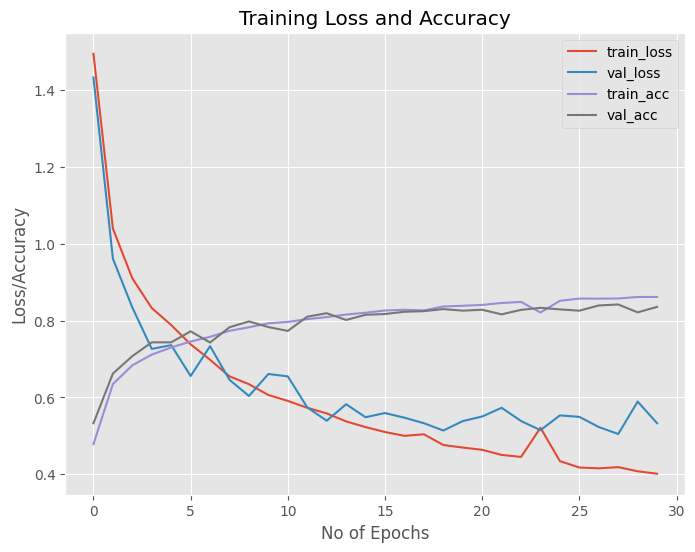

In [15]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.close('all')
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 30), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, 30), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 30), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 30), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("No of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Load the best model back

In [16]:
from tensorflow.keras.models import load_model

# Load the saved model
best_model = load_model('best_model.keras')

## Model Evaluation

In [17]:
# Final evaluation of the model
scores = model.evaluate(test_dataset, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.56%
